In [1]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
# Configurar la conexión a la base de datos
host = '<HOST>'
database = '<DATABASE>'
user = '<USER>'
password = '<PASSWORD>'
port = '<PORT>'

# Crear la cadena de conexión
connection_string = f'mysql+mysqlconnector://{user}:{password}@{host}:{port}/{database}'

# Crear la conexión
engine = create_engine(connection_string)

# Definir las tablas a cargar
tablas = ['dim_empresa', 'dim_producto', 'dim_cliente', 'dim_fecha', 'dim_categoria', 
          'fact_venta', 'fact_detalle_venta']

# Cargar las tablas en DataFrames
dataframes = {}
for tabla in tablas:
    query = f'SELECT * FROM {tabla}'
    dataframes[tabla] = pd.read_sql(query, engine)

In [3]:
# Preprocesamiento inicial
# Convertir fechas a datetime
dataframes['fact_venta']['fecha_venta'] = pd.to_datetime(dataframes['fact_venta']['fecha_venta'])
dataframes['dim_fecha']['fecha'] = pd.to_datetime(dataframes['dim_fecha']['fecha'])

# Renombrar 'empresa_id' en dim_cliente para evitar conflictos
dataframes['dim_cliente'].rename(columns={'empresa_id': 'empresa_id_cliente'}, inplace=True)

# Unir las tablas relevantes
df_ventas = pd.merge(dataframes['fact_venta'], dataframes['fact_detalle_venta'], on='venta_id', how='left')
df_ventas = pd.merge(df_ventas, dataframes['dim_producto'], on='producto_id', how='left', suffixes=('', '_producto'))
df_ventas = pd.merge(df_ventas, dataframes['dim_cliente'], on='cliente_id', how='left', suffixes=('', '_cliente'))
df_ventas = pd.merge(df_ventas, dataframes['dim_fecha'], on='fecha_id', how='left')
df_ventas = pd.merge(df_ventas, dataframes['dim_empresa'], on='empresa_id', how='left', suffixes=('', '_empresa'))
df_ventas = pd.merge(df_ventas, dataframes['dim_categoria'], on='categoria_id', how='left')

# Seleccionar variables para el modelo
df_modelo = df_ventas[['monto_total', 'precio_lista', 'cantidad', 'nombre_categoria',
                       'tipo', 'ciudad', 'estado_id', 'pais_id', 'mes', 'dia_semana', 'trimestre',]]

# Convertir variables categóricas a dummies
categorical_vars = ['nombre_categoria', 'tipo', 'ciudad', 'estado_id', 'pais_id', 'trimestre',
                    'mes', 'dia_semana']
df_modelo = pd.get_dummies(df_modelo, columns=categorical_vars, drop_first=True)

# Manejo de valores faltantes
df_modelo.dropna(inplace=True)

In [4]:
# Definir variable dependiente e independientes
y = df_modelo['monto_total']
X = df_modelo.drop('monto_total', axis=1)

# Convertir columnas booleanas a enteros
bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype(int)

# Asegurarse de que todas las columnas sean numéricas
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

# Eliminar filas con NaN resultantes de la conversión
X.dropna(inplace=True)
y = y.loc[X.index]

# Añadir constante para el intercepto
X = sm.add_constant(X)

# Ajustar el modelo de regresión inicial
modelo_sm = sm.OLS(y, X).fit()
print(modelo_sm.summary())


                            OLS Regression Results                            
Dep. Variable:            monto_total   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     304.8
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        18:36:23   Log-Likelihood:                -83429.
No. Observations:               12167   AIC:                         1.669e+05
Df Residuals:                   12149   BIC:                         1.670e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [5]:
# Eliminación de variables no significativas y multicolineales
# Eliminar meses no significativos
meses_a_eliminar = ['mes_5', 'mes_6', 'mes_7', 'mes_8', 'mes_9']
X = X.drop(columns=meses_a_eliminar, errors='ignore')

# Eliminar categorías no significativas
X = X.drop([
    'nombre_categoria_DULCERIA', 'nombre_categoria_PASTELERIA', 'nombre_categoria_PANADERIA',
    'nombre_categoria_RESTAURANTE', 'trimestre_T3'
], axis=1, errors='ignore')


# Agrupar días de fin de semana
X['Fin_de_Semana'] = X.get('dia_semana_6', 0) + X.get('dia_semana_7', 0)
dias_a_eliminar = ['dia_semana_4', 'dia_semana_6', 'dia_semana_7', 'dia_semana_5']
X = X.drop(columns=dias_a_eliminar, errors='ignore')


In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Recalcular VIF
X_no_const = X.drop('const', axis=1)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_no_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_no_const.values, i) for i in range(X_no_const.shape[1])]

print(vif_data)


        Variable       VIF
0   precio_lista  1.252400
1       cantidad  1.044534
2   dia_semana_2  1.063580
3   dia_semana_3  1.065159
4  Fin_de_Semana  1.169689


In [7]:
# Reajustar el modelo de regresión
modelo_sm = sm.OLS(y, X).fit()
print(modelo_sm.summary())

                            OLS Regression Results                            
Dep. Variable:            monto_total   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     983.7
Date:                Thu, 19 Sep 2024   Prob (F-statistic):               0.00
Time:                        18:36:23   Log-Likelihood:                -83524.
No. Observations:               12167   AIC:                         1.671e+05
Df Residuals:                   12161   BIC:                         1.671e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            65.4365      3.537     18.501

In [8]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajustar el modelo en el conjunto de entrenamiento
modelo_sm = sm.OLS(y_train, X_train).fit()

# Realizar predicciones en el conjunto de prueba
y_pred = modelo_sm.predict(X_test)

# Calcular métricas de desempeño
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse}')
print(f'R-squared: {r2}')

RMSE: 251.11936481800663
R-squared: 0.2695227089745137


In [9]:
# Mostrar coeficientes del modelo
coeficientes = pd.DataFrame({'Variable': X.columns, 'Coeficiente': modelo_sm.params})
print(coeficientes.reset_index(drop=True))

        Variable  Coeficiente
0          const    63.802986
1   precio_lista     0.667140
2       cantidad    12.231580
3   dia_semana_2    27.466227
4   dia_semana_3    51.632460
5  Fin_de_Semana    -2.258192


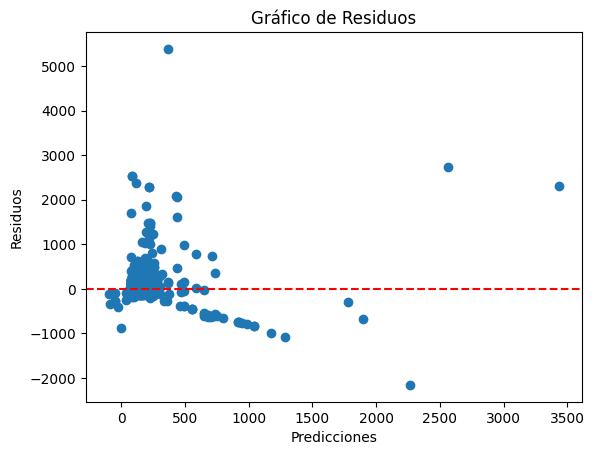

In [10]:
# Gráfico de residuos
plt.scatter(y_pred, y_test - y_pred)
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

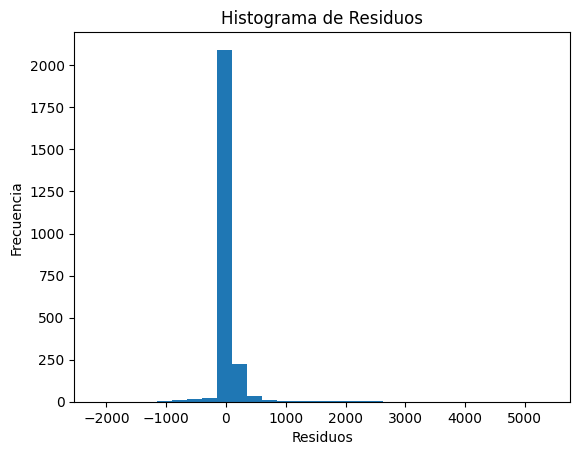

In [11]:
# Histograma de residuos
plt.hist(y_test - y_pred, bins=30)
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Residuos')
plt.show()

# **Análisis y Recomendaciones para Incrementar las Ventas**

## **Introducción**

A partir del modelo de regresión lineal múltiple desarrollado, hemos identificado factores clave que influyen significativamente en el monto total de las ventas. El objetivo de este análisis es proporcionar recomendaciones prácticas y estratégicas para mejorar las ventas de la empresa, basadas en los hallazgos estadísticos obtenidos.

---

## **Resumen de Resultados del Modelo**

El modelo tiene un **R-cuadrado de 0.287**, lo que indica que aproximadamente el 28.7% de la variabilidad en el monto total de las ventas es explicada por las variables incluidas en el modelo. A continuación, se detallan las variables significativas y su impacto en las ventas:

1. **Precio Lista** (`precio_lista`):
   - **Coeficiente**: 0.6586
   - **Interpretación**: Por cada unidad monetaria adicional en el precio de lista, el monto total de ventas aumenta en promedio en 0.6586 unidades monetarias, manteniendo constantes las demás variables.
   - **Recomendación**: Ajustar el precio de lista puede influir positivamente en las ventas, pero debe hacerse con cuidado para no afectar negativamente la demanda.

2. **Cantidad Vendida** (`cantidad`):
   - **Coeficiente**: 12.5135
   - **Interpretación**: Cada unidad adicional vendida incrementa el monto total de ventas en promedio en 12.5135 unidades monetarias.
   - **Recomendación**: Implementar estrategias que incentiven la compra de mayores cantidades, como promociones por volumen o descuentos por compras múltiples.

3. **Día de la Semana 3** (`dia_semana_3`):
   - **Coeficiente**: 41.1642
   - **Interpretación**: Las ventas en el día 3 de la semana (probablemente miércoles) son en promedio 41.1642 unidades monetarias mayores que el día de referencia.
   - **Recomendación**: Aprovechar este día con promociones especiales o eventos para maximizar las ventas.

4. **Fin de Semana** (`Fin_de_Semana`):
   - **Coeficiente**: -11.2135
   - **Interpretación**: Las ventas durante el fin de semana son en promedio 11.2135 unidades monetarias menores que el día de referencia.
   - **Recomendación**: Implementar estrategias para aumentar las ventas durante el fin de semana, como promociones especiales o actividades que atraigan a más clientes.

---

## **Recomendaciones Estratégicas**

### **1. Optimización de Precios**

- **Ajuste del Precio de Lista**:
  - Dado que el precio de lista tiene un impacto positivo en las ventas, existe la oportunidad de ajustar los precios para mejorar los ingresos.
  - **Acciones**:
    - Realizar análisis de elasticidad de precio para entender cómo cambios en el precio afectan la demanda.
    - Comunicar claramente el valor agregado de los productos para justificar cualquier incremento de precio.
    - Implementar precios psicológicos que mejoren la percepción del cliente.

### **2. Incremento de la Cantidad Vendida**

- **Promociones por Volumen**:
  - Ofrecer descuentos por la compra de múltiples unidades para incentivar compras de mayor cantidad.
- **Paquetes y Combos**:
  - Crear ofertas que agrupen varios productos a un precio especial.
- **Programas de Fidelización**:
  - Recompensar a los clientes frecuentes con beneficios que los motiven a aumentar el volumen de sus compras.

### **3. Maximizar Ventas en el Día 3**

- **Promociones Especiales los Miércoles**:
  - Implementar ofertas exclusivas o descuentos adicionales para atraer aún más clientes en este día.
- **Eventos Temáticos**:
  - Organizar eventos o actividades que incrementen el tráfico de clientes.

### **4. Aumentar Ventas durante el Fin de Semana**

- **Identificar Barreras**:
  - Investigar las razones detrás de las menores ventas en el fin de semana.
- **Estrategias de Atracción**:
  - Ofrecer promociones especiales solo disponibles durante el fin de semana.
  - Implementar actividades familiares o entretenimiento en tienda para atraer más clientes.
- **Marketing Enfocado**:
  - Realizar campañas publicitarias dirigidas a promover las ventas durante el fin de semana.

### **5. Estrategias de Marketing y Promoción**

- **Campañas Publicitarias Segmentadas**:
  - Utilizar datos demográficos y de comportamiento para dirigir campañas más efectivas.
- **Canales Digitales**:
  - Aprovechar redes sociales y correo electrónico para comunicar ofertas y eventos.
- **Colaboraciones y Alianzas**:
  - Asociarse con otras marcas o negocios locales para ampliar el alcance y atraer nuevos clientes.

### **6. Monitoreo y Evaluación Continua**

- **Seguimiento de KPIs**:
  - Establecer indicadores clave de rendimiento para medir el impacto de las estrategias implementadas.
- **Análisis de Datos en Tiempo Real**:
  - Utilizar herramientas de análisis para ajustar rápidamente las estrategias según los resultados obtenidos.
- **Feedback de Clientes**:
  - Implementar encuestas o canales de retroalimentación para comprender mejor las necesidades y preferencias de los clientes.

---

## **Conclusión**

El análisis del modelo de regresión ha revelado factores clave que afectan el monto total de las ventas. Al centrarse en estrategias que optimicen los precios, incentiven el aumento en la cantidad vendida, aprovechen los días con mayores ventas y mejoren el desempeño durante el fin de semana, la empresa puede implementar acciones concretas para incrementar sus ingresos.

Es esencial que estas recomendaciones se implementen de manera planificada y que se realice un seguimiento constante para medir su efectividad y realizar ajustes necesarios. La toma de decisiones informadas y basadas en datos será fundamental para el éxito continuo y el crecimiento de la empresa.

